# Abgabe 4: Statistische Mechanik

**Teammitglieder:** René Zarwel, Matthias Kastenmüller

<br>

Importieren allgemein benötigter Bibliotheken:

In [137]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import *
import pylab as pylab
import numpy.polynomial.polynomial as poly
import numpy as np
from numpy import *
from numpy.linalg import norm
from scipy.integrate import odeint
import math
import vpython as vp         # get VPython modules for animation
vec=vp.vector

## Aufgabe 1: Scheiben in einem Quadrat

Text(0,0.5,'Anzahl')

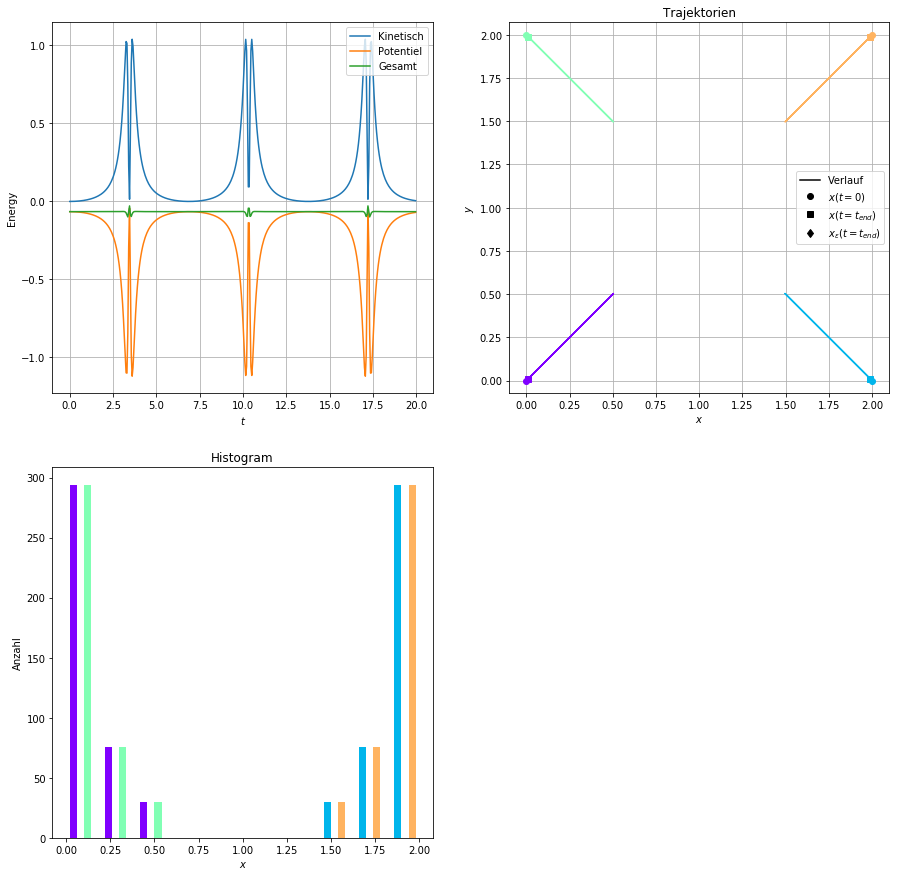

In [169]:
def init_pos_vel(d, n, box_width):
    x = linspace(0, box_width, n)
    tx = meshgrid(*[x]*d)
    pos = list(zip(*[xs.flatten() for xs in tx]))
    vel = zeros_like(pos)
    return array(pos), array(vel)


def eval_DV(i, x, DV):
    val = 0
    for j in range(len(x)):
        if j==i:
            continue
        val += DV(x[i,:]-x[j,:])
    return val


def compute_energy(x, v, V):
    Vpot = 0
    Vkin = 0
    for i in range(len(x)):
        Vkin += 0.5*dot(v[i,:],v[i,:])
        for j in range(len(x)):
            if i==j:
                continue
            Vpot += 0.5*V(norm(x[i,:]-x[j,:]))
    return Vpot+Vkin, Vpot, Vkin


def compute(x, v, DV, dt):
    n = len(x)
    xn = zeros_like(x)
    vn = zeros_like(v)

    # update positions
    for i in range(n):
        # Forces acting on x[i]
        Fij = eval_DV(i, x, DV)
        vn[i,:] = v[i,:] + dt*Fij
        xn[i,:] = x[i,:] + dt*vn[i,:]
    return xn, vn

def init(x, v, DV, dt):
    vn = zeros_like(v)
    for i in range(len(x)):
        Fij = eval_DV(i, x, DV)
        vn[i] = v[i] - 0.5*dt*Fij
    return x, vn

def finalize(x, v, t):
    v = 0.5*(v[1:,:,:] + v[:-1,:,:])
    x = x[:-1,:,:]
    t = t[:-1]
    return x, v, t



def run(x, v, V,  T=1, dt=1e-3):
    x, v = init(x, v, V, dt)
    xhist = [x]
    vhist = [v]
    thist = [0]
    nsteps = int(T/float(dt))

    for i in range(nsteps):
        x,v = compute(x, v, V, dt)
        xhist.append(x)
        vhist.append(v)
        thist.append((i+1)*dt)
    xhist, vhist, thist = finalize(array(xhist), array(vhist), array(thist))

    return array(xhist), array(vhist), array(thist)


epsilon = 1.0
sigma = 1.0
LJ = lambda r: epsilon* ((sigma/r)**12 - (sigma/r)**6)
DLJ = lambda x: 6*epsilon*(2*x*(sigma/norm(x))**14 - x*(sigma/norm(x))**8)

# dimension
d = 2
# Anz. Teilchen in jeder Dimension
N = 2
box_width = 2
T = 20
dt = 0.05

# Anfangsbedingungen
x, v = init_pos_vel(d, N, box_width)
#x = array([[0.5,1],[0.2,1.5],[1.2,0.1],[1.7,0.3]])
#v = zeros_like(x)
xhist, vhist, thist = run(x, v, DLJ, T=T, dt=dt)
data = []
for i,ti in enumerate(thist):
    E, Vpot, Vkin = compute_energy(xhist[i,:,:], vhist[i,:,:], LJ)
    data.append([E, Vpot, Vkin])
data = array(data)

# Plot der Daten
figure(figsize=(15,15))
subplot(221)
plot(thist, data[:,2], label='Kinetisch')
plot(thist, data[:,1], label='Potentiel')
plot(thist, data[:,0], label='Gesamt')
grid(True)
xlabel('$t$')
ylabel('Energy')
legend()

subplot(222)
c = []
for i in range(xhist.shape[1]):
    c.append(cm.rainbow((float(i)/xhist.shape[1])))
    plot(xhist[0,i,0], xhist[0,i,1],'o', color=c[i])
    plot(xhist[-1,i,0], xhist[-1,i,1],'s', color=c[i])
    plot(xhist[:,i,0], xhist[:,i,1], color=c[i])
axis('equal')
title('Trajektorien')
xlabel('$x$')
ylabel('$y$')
grid(True)
legend( [Line2D([],[], linestyle='-', color='k'),
         Line2D([],[], linestyle='', marker='o', color='k'),
         Line2D([],[], linestyle='', marker='s', color='k'),
         Line2D([],[], linestyle='', marker='d', color='k')],
        ["Verlauf",
         "$x(t=0)$",
         r'$x(t=t_{end})$',
         r'$x_{\epsilon}(t=t_{end})$'],
        numpoints=1)

subplot(223)
hist(xhist[:,:,0], color=c)
title('Histogram')
xlabel('$x$')
ylabel('Anzahl')

## Aufgabe 2: Monte-Carlo-Verfahren zur Integration

## Aufgabe 3: Ising-Modell

## Aufgabe 4: Simulierte Abkühlung und Problem des Handlungsreisenden